In [20]:
import pandas as pd
import sqlite3

In [21]:
try:
  connect = sqlite3.connect('../data/checking-logs.sqlite')
  print('OK. Connected to sqlite')

except sqlite3.Error as error:
  print('Error with connection:', error)

OK. Connected to sqlite


## для каждого часа посчитайте среднее количество коммитов в рабочие дни и в выходные (если за час не было коммитов, не используйте его для расчета среднего значения) используйте эти значения для своего графика, например: Пн, 17-18 : 5 коммитов, Вт, 17-18: 6 коммитов, Ср, 17-18: 7 коммитов

In [22]:
#Подготовим таблицу. Выберем из datetime отдельно день недели и время коммита, определим, является ли день выходным и уберем лишнее

query = '''
SELECT uid, timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''
commits = pd.io.sql.read_sql(query, connect, parse_dates=['timestamp'])
commits['weekday'] = commits['timestamp'].dt.dayofweek
commits['day'] = commits.timestamp.dt.day
commits['hour'] = commits.timestamp.dt.hour
commits['type'] = commits['weekday'].apply(
    lambda x: 'working_day' if x < 5 else 'weekend')
commits = commits.drop(columns = ['weekday'])
commits

,uid,timestamp,day,hour,type
0,user_4,2020-04-17 05:19:02.744528,17,5,working_day
1,user_4,2020-04-17 05:22:35.249331,17,5,working_day
2,user_4,2020-04-17 05:22:45.549397,17,5,working_day
3,user_4,2020-04-17 05:34:14.691200,17,5,working_day
4,user_4,2020-04-17 05:34:24.422370,17,5,working_day
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,21,20,working_day
3203,user_1,2020-05-21 20:22:41.785725,21,20,working_day
3204,user_1,2020-05-21 20:22:41.877806,21,20,working_day
3205,user_1,2020-05-21 20:37:00.129678,21,20,working_day


In [23]:
# Для каждого часа рассчитаем среднее количество коммитов в рабочие дни и в выходные дни (если за час коммитов не было, не используем его для вычисления среднего значения)

commits_groupped = commits.groupby(['type', 'day', 'hour']).count()
commits_groupped = commits_groupped.groupby(
    ['type', 'hour']).mean()['uid'].reset_index()
commits_groupped

,type,hour,uid
0,weekend,0,2.000000
1,weekend,1,6.000000
2,weekend,3,1.000000
3,weekend,5,2.000000
4,weekend,7,4.000000
5,weekend,8,7.000000
6,weekend,9,3.666667
7,weekend,10,7.000000
8,weekend,11,23.600000
9,weekend,12,9.500000


In [24]:
pivot_table = pd.pivot(commits_groupped,
                       values='uid',
                       index='hour',
                       columns='type')
pivot_table

type,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
3,1.000000,2.000000
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


array([<Axes: title={'center': 'weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

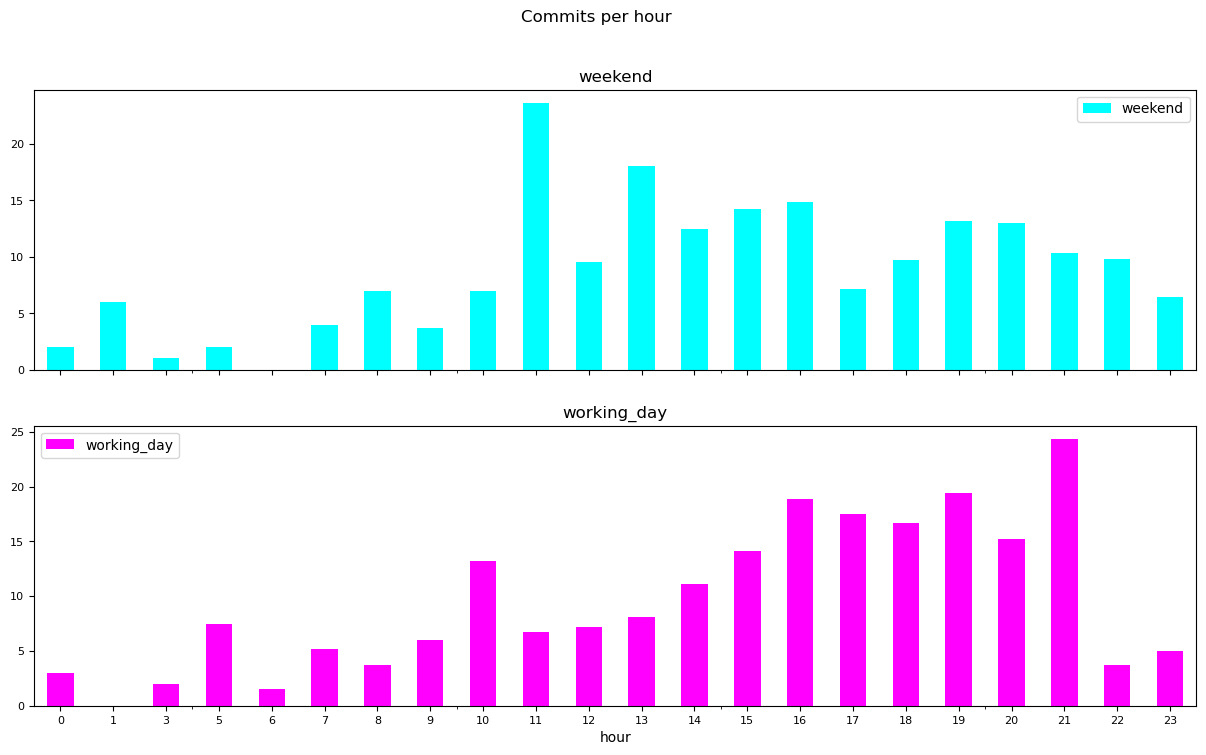

In [25]:
pivot_table.plot(kind='bar',
                      figsize=(15, 8),
                      title='Commits per hour',
                      rot=0,
                      fontsize=8,
                      colormap='cool',
                      subplots=True)

In [26]:
# Посмотрим, в какое время наибольшее количество коммитов в рабочие дни и выходные

pivot_table[pivot_table['working_day'] == pivot_table['working_day'].max()]

type,weekend,working_day
hour,,
21,10.285714,24.333333


### Час, когда в выходные дни наибольшее количество коммитов - 21

In [27]:
pivot_table[pivot_table['weekend'] == pivot_table['weekend'].max()]

type,weekend,working_day
hour,,
11,23.6,6.769231


### Час, когда в рабочие дни наибольшее количество коммитов - 11

### Вывод: динамика в рабочие и выходные дни отличается. В рабочие дни пик коммитов смещен на вечер, а в выходные на утро.

In [28]:
connect.close()